In [2]:
onedrive = r"C:\Users\mikek\OneDrive"
# %matplotlib ipympl
# %matplotlib qt
# %matplotlib widget
%matplotlib inline

from boututils.datafile import DataFile
from boutdata.collect import collect
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys, pathlib
import platform
import traceback
import xarray
import xbout
import scipy
import re

onedrive_path = str(os.getcwd()).split("OneDrive")[0] + "OneDrive"
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\sdtools"))
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\soledge"))
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages"))

from gridtools.hypnotoad_tools import *
from gridtools.b2_tools import *
from gridtools.utils import *

from hermes3.fluxes import *
from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *
from hermes3.utils import *
from code_comparison.code_comparison import *
# from code_comparison.viewer_2d import *
import matplotlib as mpl

%load_ext autoreload
%autoreload 2


print("Done")


st40_phys_viewer can not be loaded from outside Tokamak Energy!

Done


In [2]:
db = CaseDB()

toload = {
    "base0" : "sta10a-bestshot",
    # "base1" : "sta10b-ar1pc",
    # "base2" : "sta10c-ar2pc",
    # "base4" : "sta10d-ar4pc",
    # "vis0" : "sta11a-ion_viscosity",
    # "vis1" : "sta11b-ar1pc",
    # "vis2" : "sta11c-ar2pc",
    # "vis4" : "sta11d-ar4pc",
}

cs = dict()   # casestore

for name in toload:
    print(f"Loading {toload[name]}")
    cs[name] = Load.case_1D(os.path.join(onedrive_path, rf"Project\collab\tech\cases\step1d\{toload[name]}"))


Loading sta10a-bestshot


c:\Users\mikek\anaconda3\envs\new\lib\site-packages\dask\array\core.py:4828: PerformanceWarning: Increasing number of chunks by factor of 32
  result = blockwise(


In [18]:
write_file(cs, "a2.pkl")

a2.pkl written


In [2]:
cs = read_file("a2.pkl")

a2.pkl loaded


## Reconstruct input script function

In [3]:
ds = cs["base0"].ds
o = ds.options

o["mesh"].keys()
ny = o["mesh"]["ny"]
length = o["mesh"]["length"]
dymin = o["mesh"]["dymin"]
dy_out = ds["dy"].values

In [ ]:
casechoice = "sd5-dc2-5"
# nout = BoutData(path(casechoice))["options"]["NOUT"]
# ny = BoutData(path(casechoice))["options"]["mesh"]["ny"]
# length = BoutData(path(casechoice))["options"]["mesh"]["length"]
# dymin = BoutData(path(casechoice))["options"]["mesh"]["dymin"]
# rho_s0 = BoutData(path(casechoice))["outputs"]["rho_s0"]
# dy_out = collect("dy", path=path(casechoice), yguards=True, info = False, strict = True)[0,1:-1]
def replace_guards(var):
    """
    This in-place replaces the points in the guard cells with the points on the boundary
    MK MODIFIED TO NOT BE IN PLACE
    """
    out = np.array(var)
    out[0] = 0.5*(out[0] + out[1])
    out[-1] = 0.5*(out[-1] + out[-2])
    
    return out

# Grid from the case
y = np.linspace(0, 2*np.pi, num = (ny+2))
ypos_out = np.zeros(len(dy_out))
ypos_out[0] = -0.5*dy_out[1]
ypos_out[1] = 0.5*dy_out[1]

for i in range(2,len(dy_out)):
    ypos_out[i] = ypos_out[i-1] + 0.5*dy_out[i-1] + 0.5*dy_out[i]
    
ypos_out_gr = replace_guards(ypos_out)

# Reconstructed grid
# ny = 100
# dymin = 0.01
y = np.linspace(0, 2*np.pi, num = (ny+2))

# Width of all domain cells. I assume guard cells just repeat the widths of the adjacent ones
dy = (length/ny) * (1 + (1-dymin) * (1-y/np.pi) )

ypos = np.zeros(len(dy))
ypos[0] = -0.5*dy[1]
ypos[1] = 0.5*dy[1]

for i in range(2,len(dy)):
    ypos[i] = ypos[i-1] + 0.5*dy[i-1] + 0.5*dy[i]

ypos_gr = replace_guards(ypos)

In [6]:
%matplotlib widget

### X-point is at 58m.

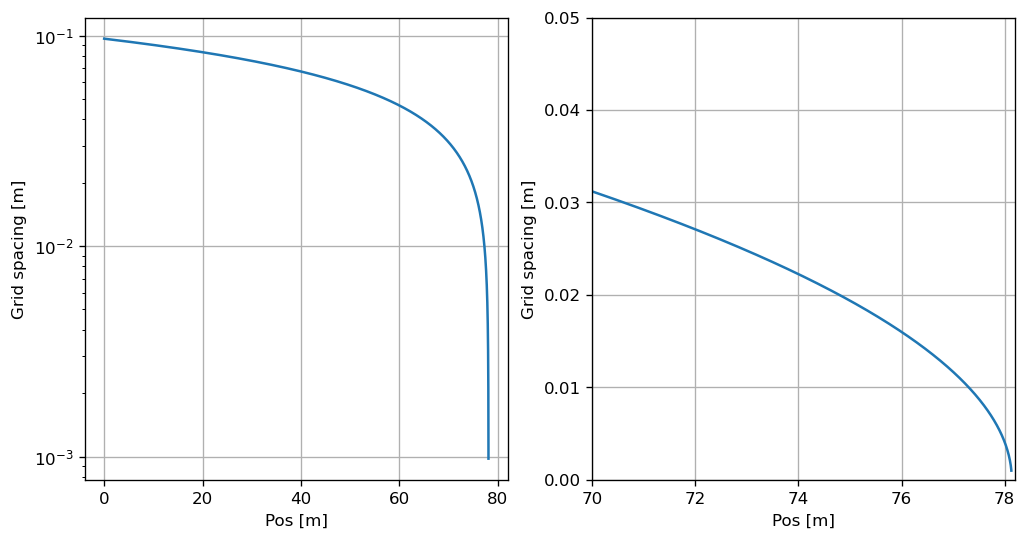

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(10,5), dpi = 120)

ax = axes[0]
ax.plot(ypos_gr, dy)
ax.set_yscale("log")

ax = axes[1]
ax.plot(ypos_gr, dy)
ax.set_xlim(70,78.2)
ax.set_ylim(0,0.05)

for ax in axes:
    ax.grid()
    ax.set_xlabel("Pos [m]")
    ax.set_ylabel("Grid spacing [m]")
    # ax.set_yscale("log")

## Simple logistic

Sum of cells: 74.55
Desired sum: 47.98
Multiplying by factor: 1.05
Integral: 22.69150000345646
Xpoint index: 184
Input file function: 0.3 + (0.001 - 0.3)


Text(0.5, 1.0, 'Cell width distribution')

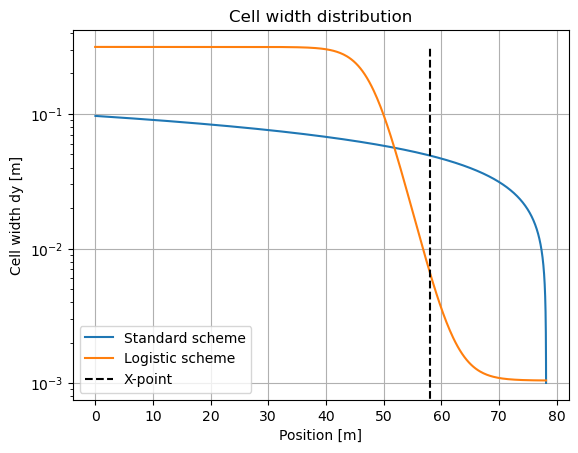

In [23]:
length = 78.13
length_xpt = 57.98    # xpoint position [m]

# A = 0.15    # Left asymptote
# K = 0.001   # Right asymptote
# B = 0.4
# s = xpoint - 10
# ny = 800
# length = 78

A = 0.3    # Left asymptote
K = 0.001   # Right asymptote
B = 0.4
s = length_xpt - 10
ny = 400 + 4


x = np.linspace(0, length, ny)

ypi = np.linspace(0, 2*np.pi, num = (ny))

# so x = ypi / ((2*np.pi) * L)
dy = A + (K - A) / (1 + np.exp(-B * ( (ypi/(2*np.pi) * length) - s)))

print(f"Sum of cells: {sum(dy):.2f}")
print(f"Desired sum: {s:.2f}")

factor = length / sum(dy)
dy *= factor
print(f"Multiplying by factor: {factor:.2f}")
int = ( (K-A) * np.log( np.exp(B*(s-length)+1)) / B + K*length ) - ( (K-A) * np.log(np.exp(B*s) + 1)/B) 
print(f"Integral: {int}")
y = np.cumsum(dy)
xpoint_idx = abs(y - length_xpt).argmin()

print(f"Xpoint index: {xpoint_idx}")
print(f"Input file function: {A} + ({K} - {A})")

fig, ax = plt.subplots(dpi = 100)
ds = cs["base0"].ds.isel(pos=slice(2,-2))
ax.plot(ds["pos"], ds["dy"], label = "Standard scheme")
ax.plot(x, dy, label = "Logistic scheme")
ax.vlines(length_xpt, 0, max(dy), color = "k", label = "X-point", ls = "--")
# ax.vlines(y[xpoint_idx], 0, max(dy), color = "k", label = "X-point", ls = "--")

# dy.plot(ax = ax, label = "Old")

ax.set_xlabel("Position [m]")
ax.set_ylabel("Cell width dy [m]")
ax.grid()
ax.legend(loc=("lower left"))
ax.set_yscale("log")
ax.set_title("Cell width distribution")


## Compare with code output

Text(0.5, 1.0, 'Cell width distribution')

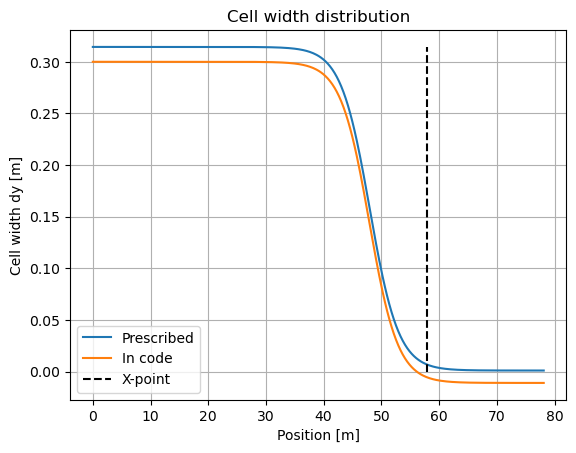

In [17]:
test = pd.read_csv(r"dy_test_out.csv", header = 0)

fig, ax = plt.subplots(dpi = 100)
ds = cs["base0"].ds.isel(pos=slice(2,-2))
# ax.plot(ds["pos"], ds["dy"], label = "Standard scheme")
ax.plot(x, dy, label = "Prescribed")
ax.plot(x, test["dy"], label = "In code")
ax.vlines(length_xpt, 0, max(dy), color = "k", label = "X-point", ls = "--")
# ax.vlines(y[xpoint_idx], 0, max(dy), color = "k", label = "X-point", ls = "--")

# dy.plot(ax = ax, label = "Old")

ax.set_xlabel("Position [m]")
ax.set_ylabel("Cell width dy [m]")
ax.grid()
ax.legend(loc=("lower left"))
# ax.set_yscale("log")
ax.set_title("Cell width distribution")

## Trying to derive input file

Sum of cells: 77.53
Desired sum: 47.98


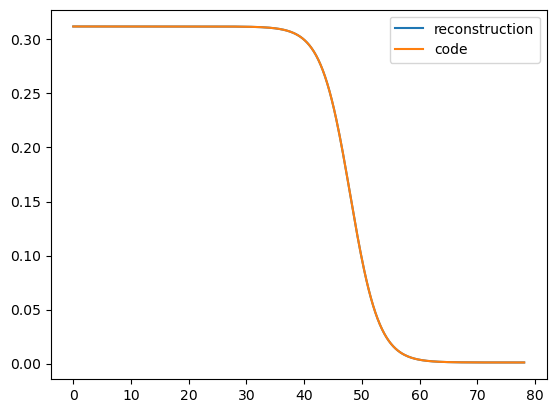

In [61]:
A = 0.3    # LHS asymptote
K = 0.001    # RHS asymptote
B = 0.4   # Gradient
s = length_xpt - 10    # Gradient location
factor = 1.04    # Needed to scale function to have correct length, calculated in python
ny = 404
length = 78.13           # Length of the domain in meters
length_xpt = 57.98   # Length from midplane to X-point [m]
y = np.linspace(0, 2*np.pi, num = (ny))
ypos = y/(2*np.pi) * length

# Matches code and is wrong
dycheck = (A + (K - A) / (1 + np.exp(-B * ( (y/(2*np.pi) * length) - s)))) * factor

# This should work
# length = 78.13
# length_xpt = 57.98    # xpoint position [m]
# A = 0.3    # Left asymptote
# K = 0.001   # Right asymptote
# B = 0.4
# s = length_xpt - 10
# ny = 400 + 4

# ypi = np.linspace(0, 2*np.pi, num = (ny))
dy = A + (K - A) / (1 + np.exp(-B * ( (ypi/(2*np.pi) * length) - s))) 
# factor = length / sum(dy)
dy *= factor


print(f"Sum of cells: {sum(dy):.2f}")
print(f"Desired sum: {s:.2f}")

fig, ax = plt.subplots()
ax.plot(ypos, dy, label = "reconstruction")
ax.plot(ypos, dycheck, label = "code")
ax.legend()


## 1600 point version

Factor: 1.0088836215043009
Xpoint index is 1190


Text(0.5, 1.0, 'Cell width distribution')

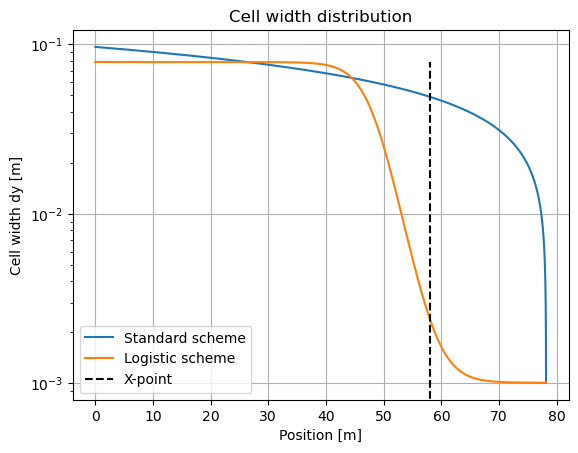

In [80]:
length = 78.13
length_xpt = 57.98    # xpoint position [m]
A = 0.078    # Left asymptote
K = 0.001   # Right asymptote
B = 0.4
s = length_xpt - 10
ny = 1600 + 4
x = np.linspace(0, length, ny)
ypi = np.linspace(0, 2*np.pi, num = (ny))
ypos = ypi/(2*np.pi) * length
dy = A + (K - A) / (1 + np.exp(-B * ( (ypi/(2*np.pi) * length) - s)))
factor = length / sum(dy)
dy *= factor
print(f"Factor: {factor}")
xpoint_idx = abs(ypos - length_xpt).argmin()
print(f"Xpoint index is {xpoint_idx}")
fig, ax = plt.subplots(dpi = 100)
ds = cs["base0"].ds.isel(pos=slice(2,-2))
ax.plot(ds["pos"], ds["dy"], label = "Standard scheme")
ax.plot(x, dy, label = "Logistic scheme")
ax.vlines(length_xpt, 0, max(dy), color = "k", label = "X-point", ls = "--")
# ax.vlines(y[xpoint_idx], 0, max(dy), color = "k", label = "X-point", ls = "--")

# dy.plot(ax = ax, label = "Old")

ax.set_xlabel("Position [m]")
ax.set_ylabel("Cell width dy [m]")
ax.grid()
ax.legend(loc=("lower left"))
ax.set_yscale("log")
ax.set_title("Cell width distribution")


##  400 lower fineres version

Factor: 1.00694526269122
Xpoint index is 299
Fine asymptote: 0.0030


Text(0.5, 1.0, 'Cell width distribution')

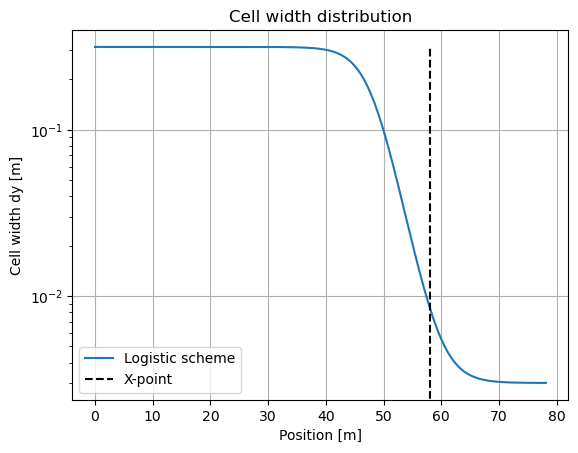

In [26]:
length = 78.13
length_xpt = 57.98    # xpoint position [m]
A = 0.311    # Left asymptote
K = 0.003   # Right asymptote
B = 0.4
s = length_xpt - 10
ny = 400 + 4
x = np.linspace(0, length, ny)
ypi = np.linspace(0, 2*np.pi, num = (ny))
ypos = ypi/(2*np.pi) * length
dy = A + (K - A) / (1 + np.exp(-B * ( (ypi/(2*np.pi) * length) - s)))
factor = length / sum(dy)
dy *= factor
print(f"Factor: {factor}")
xpoint_idx = abs(ypos - length_xpt).argmin()
print(f"Xpoint index is {xpoint_idx}")
print(f"Fine asymptote: {dy[-1]:.4f}")
fig, ax = plt.subplots(dpi = 100)

ax.plot(x, dy, label = "Logistic scheme")
ax.vlines(length_xpt, 0, max(dy), color = "k", label = "X-point", ls = "--")
# ax.vlines(y[xpoint_idx], 0, max(dy), color = "k", label = "X-point", ls = "--")

# dy.plot(ax = ax, label = "Old")

ax.set_xlabel("Position [m]")
ax.set_ylabel("Cell width dy [m]")
ax.grid()
ax.legend(loc=("lower left"))
ax.set_yscale("log")
ax.set_title("Cell width distribution")


##  Version with derived left asymptote and renamed variables
- Doesn't work, the length changes
- Doing offset on A doesn't work either

Coarse asymptote: 2.257
Length: 715.6601539949621
Factor to get correct length: 0.109
Offset to get correct length: -637.530
Xpoint index is 299
Fine asymptote: 1.0000


Text(0.5, 1.0, 'Cell width distribution')

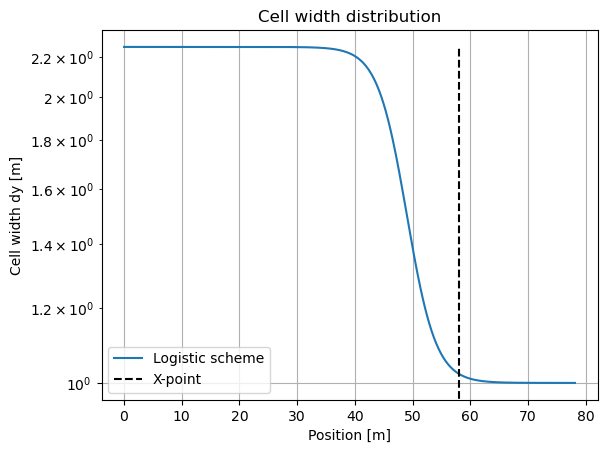

In [102]:
length = 78.13
length_xpt = 57.98    # xpoint position [m]
A = 0.1    # Left asymptote
K = 1   # Right asymptote
B = 0.4
s = length_xpt - 10
ny = 400 + 4

A = -K - (B * length * (1+K)) / (np.log( (np.exp(B*(s-length)) + 1) / (np.exp(B*s) + 1) )) 

print(f"Coarse asymptote: {A:.3f}")
x = np.linspace(0, length, ny)
ypi = np.linspace(0, 2*np.pi, num = (ny))
ypos = ypi/(2*np.pi) * length
dy = A + (K - A) / (1 + np.exp(-B * ( (ypi/(2*np.pi) * length) - s)))

int_L = (K-A) * np.log(np.exp(B*(s-length)) + 1)/B + K*length
int_0 = (K-A) * np.log(np.exp(B*s + 1))/B 

# factor = length / sum(dy)
# dy *= factor
print(f"Length: {sum(dy)}")
print(f"Factor to get correct length: {length/sum(dy):.3f}")
print(f"Offset to get correct length: {length - sum(dy):.3f}")
xpoint_idx = abs(ypos - length_xpt).argmin()
print(f"Xpoint index is {xpoint_idx}")
print(f"Fine asymptote: {dy[-1]:.4f}")
fig, ax = plt.subplots(dpi = 100)

ax.plot(x, dy, label = "Logistic scheme")
ax.vlines(length_xpt, 0, max(dy), color = "k", label = "X-point", ls = "--")
# ax.vlines(y[xpoint_idx], 0, max(dy), color = "k", label = "X-point", ls = "--")

# dy.plot(ax = ax, label = "Old")

ax.set_xlabel("Position [m]")
ax.set_ylabel("Cell width dy [m]")
ax.grid()
ax.legend(loc=("lower left"))
ax.set_yscale("log")
ax.set_title("Cell width distribution")


In [41]:
length = 78.13
length_xpt = 57.98    # xpoint position [m]
A = 0.3    # Left asymptote
K = 0.001   # Right asymptote
B = 0.4
s = length_xpt - 10
ny = 400 + 4

ypi = np.linspace(0, 2*np.pi, num = (ny))
dy = A + (K - A) / (1 + np.exp(-B * ( (ypi/(2*np.pi) * length) - s)))
factor = length / sum(dy)
dy *= factor
dy[-10:]

array([0.00105165, 0.00105138, 0.00105112, 0.00105089, 0.00105068,
       0.00105048, 0.00105029, 0.00105012, 0.00104996, 0.00104982])

In [106]:
ny = 100   # number of points without guards

ypi = np.linspace(0, 2*np.pi, num = (ny+2))
x = ypi/(2*np.pi) * L
x

array([ 0.        ,  0.77227723,  1.54455446,  2.31683168,  3.08910891,
        3.86138614,  4.63366337,  5.40594059,  6.17821782,  6.95049505,
        7.72277228,  8.4950495 ,  9.26732673, 10.03960396, 10.81188119,
       11.58415842, 12.35643564, 13.12871287, 13.9009901 , 14.67326733,
       15.44554455, 16.21782178, 16.99009901, 17.76237624, 18.53465347,
       19.30693069, 20.07920792, 20.85148515, 21.62376238, 22.3960396 ,
       23.16831683, 23.94059406, 24.71287129, 25.48514851, 26.25742574,
       27.02970297, 27.8019802 , 28.57425743, 29.34653465, 30.11881188,
       30.89108911, 31.66336634, 32.43564356, 33.20792079, 33.98019802,
       34.75247525, 35.52475248, 36.2970297 , 37.06930693, 37.84158416,
       38.61386139, 39.38613861, 40.15841584, 40.93069307, 41.7029703 ,
       42.47524752, 43.24752475, 44.01980198, 44.79207921, 45.56435644,
       46.33663366, 47.10891089, 47.88118812, 48.65346535, 49.42574257,
       50.1980198 , 50.97029703, 51.74257426, 52.51485149, 53.28

In [2]:
250-66

184

In [9]:
int

19.36666666671023

Text(0.5, 47.7222222222222, 'Position (m)')

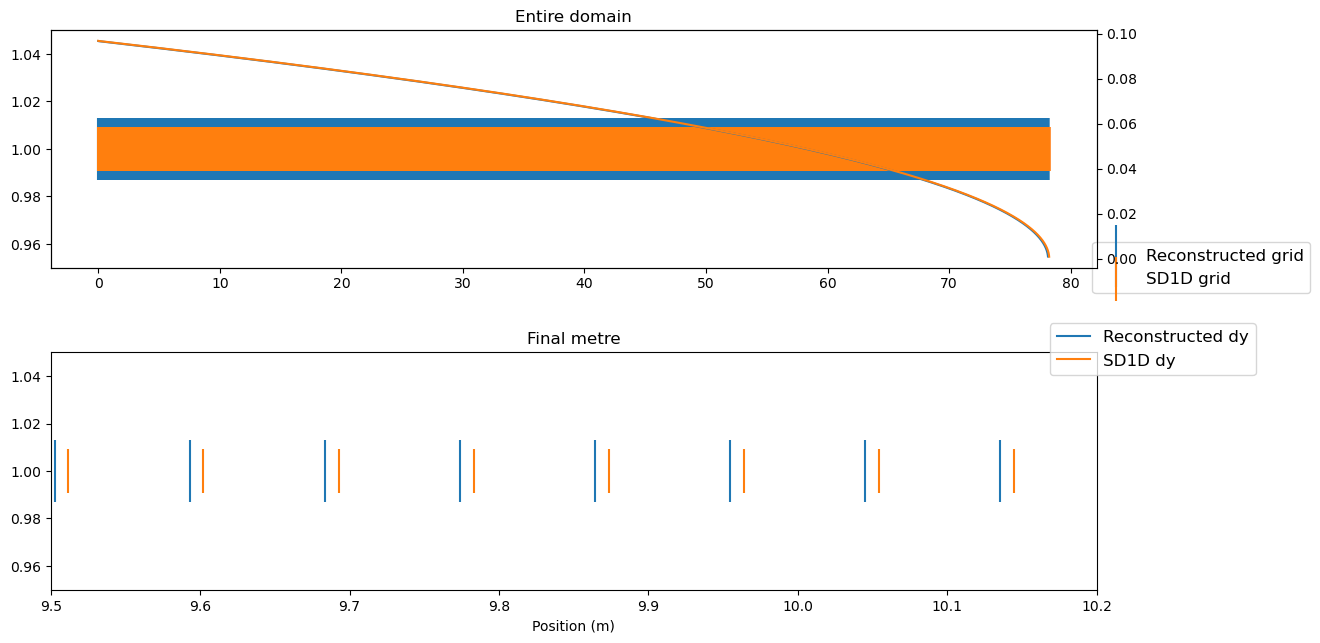

In [56]:
plt.close("all")
fig, ax = plt.subplots(2,1,figsize = (12,7))
fig.tight_layout(pad = 4)



ax[0].scatter(ypos_gr, [1]*len(ypos_gr), marker = "|", s = 2000, label = "Reconstructed grid")
ax[0].scatter(ypos_out_gr, [1]*len(ypos_out_gr), marker = "|", s = 1000, label = "SD1D grid")
ax2 = ax[0].twinx()
ax2.plot(ypos_gr, dy, label = "Reconstructed dy")
ax2.plot(ypos_out_gr, dy_out, label = "SD1D dy")
ax[0].set_ylim(0.95, 1.05)

ax[0].legend(bbox_to_anchor=(1.1, 0), loc = "center", fontsize = 12)
ax2.legend(bbox_to_anchor=(1.16,-0.2), fontsize = 12)
ax[0].set_title("Entire domain")

ax[1].scatter(ypos_gr, [1]*len(ypos_gr), marker = "|", s = 2000, label = "Reconstructed grid")
ax[1].scatter(ypos_out_gr, [1]*len(ypos_out_gr), marker = "|", s = 1000, label = "SD1D grid")
ax[1].set_ylim(0.95, 1.05)
ax[1].set_xlim(9.5, 10.2)
ax[1].set_title("Final metre")
ax[1].set_xlabel("Position (m)")